# Exercise 13: Structured light

## 3D scanning

In [227]:
# Imports
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import seaborn as sns

sns.set_theme(palette=sns.color_palette("twilight_shifted"))

In [31]:
# Functions for visualization
def plot(img, size=6, color_map="gray"):
    fig, ax = plt.subplots(1, figsize=(size,size))
    ax.imshow(img, cmap=color_map)
    plt.grid(False)
    plt.show()

def plot_multi(imgarr, color_map="gray"):
    fig, axarr = plt.subplots(1, len(imgarr), figsize=(6*len(imgarr), 6))
    for img, ax in zip(imgarr, axarr):
        ax.imshow(img, cmap=color_map)
        ax.grid(False) 

    plt.show()

In [6]:
c = np.load('data/calib.npy', allow_pickle=True).item()
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

In [7]:
K0 = c["K0"]
d0 = c["d0"]

K1 = c["K1"]
d1 = c["d1"]

R = c["R"]
t = c["t"]

### Exercise 13.1

Intrinsics: K0 and K1
Extrinsics: R and t

### Exercise 13.2

In [8]:
im0 = cv2.imread("data/sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(K0, d0, K1, d1, size, R, t, flags=0)
R0, R1, P0, P1 = stereo[:4]

# Maps for rectification
maps0 = cv2.initUndistortRectifyMap(K0, d0, R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(K1, d1, R1, P1, size, cv2.CV_32FC2)

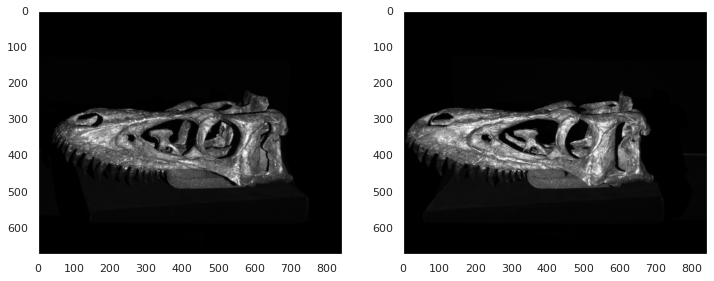

((26, 676, 844), (26, 676, 844))

In [85]:
# Rectify images
ims0 = []
ims1 = []

for i in range(26):
    # image0 = cv2.imread(f"data/sequence/frames0_{i}.png", cv2.IMREAD_GRAYSCALE) / 255
    image0 = cv2.imread(f"data/sequence/frames0_{i}.png") / 255
    image0 = np.mean(image0, axis=2) 
    # image1 = cv2.imread(f"data/sequence/frames1_{i}.png", cv2.IMREAD_GRAYSCALE) / 255
    image1 = cv2.imread(f"data/sequence/frames1_{i}.png") / 255
    image1 = np.mean(image1, axis=2) 
    ims0.append(cv2.remap(image0, *maps0, cv2.INTER_LINEAR))
    ims1.append(cv2.remap(image1, *maps1, cv2.INTER_LINEAR))

ims0 = np.array(ims0)
ims1 = np.array(ims1)

plot_multi([ims0[0], ims1[0]])
ims0.shape, ims1.shape

### Exercise 13.3

In [129]:
def unwrap(ims, n1=40):
    primary_images = ims[2:18]
    secondary_images = ims[18:]

    # Phases
    fft_primary = np.fft.rfft(primary_images, axis=0)
    theta_primary = np.angle(fft_primary[1]) 

    fft_secondary = np.fft.rfft(secondary_images, axis=0)
    theta_secondary = np.angle(fft_secondary[1])

    # Phase cue
    theta_c = np.mod(theta_secondary - theta_primary, 2 * np.pi)
    
    # Primary order
    primary_order = np.round(((n1 * theta_c) - theta_primary) / (2 * np.pi), 100)

    # Unwrapped phase
    theta_est = (((2 * np.pi * primary_order) + theta_primary) / n1) 
    
    return theta_est

In [1]:
theta0 = unwrap(ims0)
theta1 = unwrap(ims1)

plot_multi([theta0, theta1], color_map="plasma")

NameError: name 'unwrap' is not defined

### Exercise 13.4

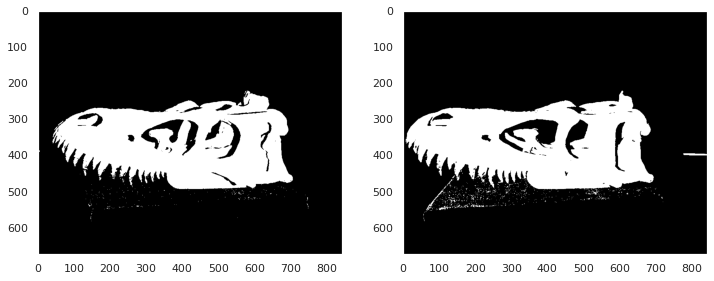

In [132]:
th = 15 / 255
difference0 = ims0[0] - ims0[1]
difference1 = ims1[0] - ims1[1]

mask0 = difference0 > th
mask1 = difference1 > th

plot_multi([mask0, mask1])

### Exercise 13.5

In [98]:
q0s = []
q1s = []

for i in range(mask0.shape[0]):
    for j in range(mask0.shape[1]):
        # Check if the pixel is valid
        if mask0[i, j]: 
            theta0_val = theta0[i, j]

            theta1_val = np.inf
            theta1_val_index = 0
            for j1 in range(mask1.shape[1]):
                if mask1[i, j1] and (np.abs(theta1[i, j1] - theta0_val)) < theta1_val:

                    theta1_val = np.abs(theta1[i, j1] - theta0_val)
                    theta1_val_index = j1



            q0s.append([j, i])
            q1s.append([theta1_val_index, i])
                    
q0s = np.array(q0s)
q1s = np.array(q1s)

q0s.shape, q1s.shape

((112671, 2), (112671, 2))

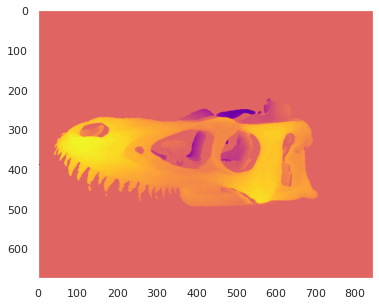

In [128]:
disparity = np.zeros(mask0.shape)

for (j0, i0), (j1, i1) in zip(q0s, q1s):
    disparity[i0, j0] = j0 - j1

disparity = cv2.medianBlur(disparity.astype(np.float32), 5)
plot(disparity, color_map="plasma")

### Exercise 13.6

In [136]:
# Tranform from homogeneous to inhomogeneous coordinates
def h_to_inh(points):
    # Convert to inhomogeneous dividing each point by the last 
    # coordinate and then removing it 
    points = points[:-1] / points[-1:]

    return points

In [263]:
points0 = np.array(q0s).astype(np.float32).T
points1 = np.array(q1s).astype(np.float32).T

points3d = cv2.triangulatePoints(P0, P1, points0, points1)
points3d_inh = h_to_inh(points3d)

In [264]:
color = []

for (j0, i0), (j1, i1) in zip(q0s, q1s):
    color.append(j0 - j1)

color = np.array(color)
color = cv2.medianBlur(color.astype(np.float32), 5)

cmap = matplotlib.cm.get_cmap('plasma')
norm = matplotlib.colors.Normalize(vmin=color.min(), vmax=color.max())
rgb_colors = []

for c in color:
    rgb_colors.append(cmap(norm(c))[0, :3])

rgb_colors = np.array(rgb_colors)

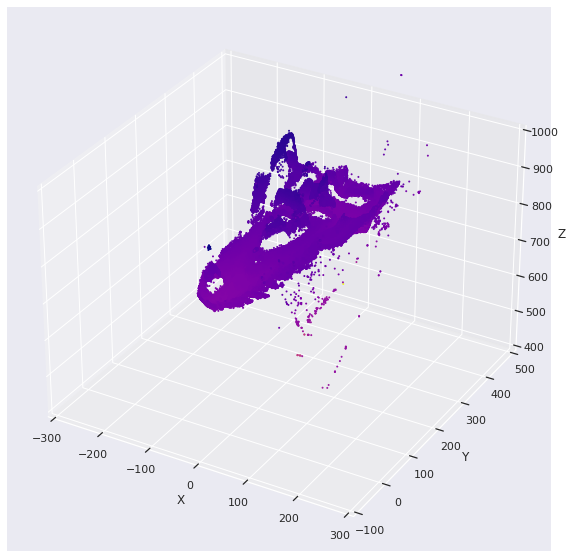

In [266]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(points3d_inh[1], points3d_inh[0], points3d_inh[2],
           c=rgb_colors, s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-300, 300])
ax.set_ylim([-100, 500])
ax.set_zlim([400, 1000])

# ax.azim = 10
# ax.dist = 10
# ax.elev = 10

plt.show()

In [268]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d_inh.T)
pcd.colors = o3d.utility.Vector3dVector(rgb_colors) 
o3d.visualization.draw_geometries([pcd])